# Data analysis workflow for the study "Pairs of amino acids at the P- and A-sites of the ribosome predictably and causally modulate translation-elongation rates"

### List of data used in this study

1. Jan, C. H., Williams, C. C., & Weissman, J. S. (2014). Principles of ER cotranslational translocation revealed by proximity-specific ribosome profiling. Science, 346(6210).

2. Williams, C. C., Jan, C. H., & Weissman, J. S. (2014). Targeting and plasticity of mitochondrial proteins revealed by proximity-specific ribosome profiling. Science, 346(6210), 748-751.

3. Young, D. J., Guydosh, N. R., Zhang, F., Hinnebusch, A. G., & Green, R. (2015). Rli1/ABCE1 recycles terminating ribosomes and controls translation reinitiation in 3′ UTRs in vivo. Cell, 162(4), 872-884.

4. Weinberg, D. E., Shah, P., Eichhorn, S. W., Hussmann, J. A., Plotkin, J. B., & Bartel, D. P. (2016). Improved ribosome-footprint and mRNA measurements provide insights into dynamics and regulation of yeast translation. Cell reports, 14(7), 1787-1799.

5. Nissley, D. A., Sharma, A. K., Ahmed, N., Friedrich, U. A., Kramer, G., Bukau, B., & O’Brien, E. P. (2016). Accurate prediction of cellular co-translational folding indicates proteins can switch from post-to co-translational folding. Nature communications, 7(1), 1-13.



### Defining the constant variables and imports that will be used to run our analyses

In [81]:
from __future__ import division
import matplotlib
import numpy as np
import math
import os
import pickle
from optparse import OptionParser
import matplotlib.backends.backend_pdf as pdf
from scipy import stats
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.table import Table
import sys
import statsmodels.sandbox.stats.multicomp as mc
import operator as op
from matplotlib.ticker import FormatStrFormatter
from time import localtime, strftime
import itertools
from matplotlib import rcParams
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.pyplot as plt



CODON_TYPES = ['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA', 'AUG', 'GUU', 'GUC', 'GUA',
               'GUG', 'UCU', 'UCC', 'UCA', 'UCG', 'CCU', 'CCC', 'CCA', 'CCG', 'ACU', 'ACC', 'ACA', 'ACG', 'GCU', 'GCC',
               'GCA', 'GCG', 'UAU', 'UAC', 'CAU', 'CAC', 'CAA', 'CAG', 'AAU', 'AAC', 'AAA', 'AAG', 'GAU', 'GAC', 'GAA',
               'GAG', 'UGU', 'UGC', 'UGG', 'CGU', 'CGC', 'CGA', 'CGG', 'AGU', 'AGC', 'AGA', 'AGG', 'GGU', 'GGC', 'GGA',
               'GGG', 'UAA', 'UAG', 'UGA']

genetic_code = {'UUU': 'F', 'UCU': 'S', 'UAU': 'Y', 'UGU': 'C', 'UUC': 'F', 'UCC': 'S', 'UAC': 'Y', 'UGC': 'C',
                'UUA': 'L', 'UCA': 'S', 'UAA': '*', 'UGA': '*', 'UUG': 'L', 'UCG': 'S', 'UAG': '*', 'UGG': 'W',
                'CUU': 'L', 'CCU': 'P', 'CAU': 'H', 'CGU': 'R', 'CUC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',
                'CUA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R', 'CUG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',
                'AUU': 'I', 'ACU': 'T', 'AAU': 'N', 'AGU': 'S', 'AUC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',
                'AUA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R', 'AUG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',
                'GUU': 'V', 'GCU': 'A', 'GAU': 'D', 'GGU': 'G', 'GUC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',
                'GUA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G', 'GUG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G'}

# In the following dict, synonymous codons for each amino acid are grouped in list such that they are decoded by similar tRNA.
# For example, in amino acid 'A', GCU and GCC codons are decoded by one type of tRNA while GCA and GCG are decoded by another kind of tRNA
synonymous = {'A': [['GCU', 'GCC'], ['GCA', 'GCG']],
              'C': [['UGU', 'UGC']],
              'D': [['GAU', 'GAC']],
              'E': [['GAA'], ['GAG']],
              'F': [['UUU', 'UUC']],
              'G': [['GGU', 'GGC'], ['GGA'], ['GGG']],
              'H': [['CAU', 'CAC']],
              'I': [['AUU', 'AUC'], ['AUA']],
              'K': [['AAG'], ['AAA']],
              'L': [['UUG'], ['UUA'], ['CUC', 'CUU'], ['CUA', 'CUG']],
              'M': [['AUG']],
              'N': [['AAU', 'AAC']],
              'P': [['CCA', 'CCG'], ['CCU', 'CCC']],
              'Q': [['CAA'], ['CAG']],
              'R': [['AGA'], ['CGU', 'CGC'], ['CGG', 'CGA'], ['AGG']],
              'S': [['UCU', 'UCC'], ['AGU', 'AGC'], ['UCA'], ['UCG']],
              'T': [['ACU', 'ACC'], ['ACA'], ['ACG']],
              'V': [['GUU', 'GUC'], ['GUG'], ['GUA']],
              'W': [['UGG']],
              'Y': [['UAU', 'UAC']],
              '*': [['UAA', 'UAG', 'UGA']]
              }

AMINO_ACIDS = ['A', 'R', 'D', 'N', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '*']

base_pairing = {'A': {'Wobble': ['GCC', 'GCG'], 'Watson-Crick': ['GCA', 'GCU']},
                'C': {'Wobble': ['UGU'], 'Watson-Crick': ['UGC']},
                'D': {'Wobble': ['GAU'], 'Watson-Crick': ['GAC']},
                'E': {'Wobble': [], 'Watson-Crick': ['GAA', 'GAG']},
                'F': {'Wobble': ['UUU'], 'Watson-Crick': ['UUC']},
                'G': {'Wobble': ['GGU'], 'Watson-Crick': ['GGA', 'GGC', 'GGG']},
                'H': {'Wobble': ['CAU'], 'Watson-Crick': ['CAC']},
                'I': {'Wobble': ['AUC'], 'Watson-Crick': ['AUA', 'AUU']},
                'K': {'Wobble': [], 'Watson-Crick': ['AAA', 'AAG']},
                'L': {'Wobble': ['CUG', 'CUU'], 'Watson-Crick': ['CUA', 'CUC', 'UUA', 'UUG']},
                'M': {'Wobble': [], 'Watson-Crick': ['AUG']},
                'N': {'Wobble': ['AAU'], 'Watson-Crick': ['AAC']},
                'P': {'Wobble': ['CCC', 'CCG'], 'Watson-Crick': ['CCA', 'CCU']},
                'Q': {'Wobble': [], 'Watson-Crick': ['CAA', 'CAG']},
                'R': {'Wobble': ['CGA', 'CGC'], 'Watson-Crick': ['AGA', 'AGG', 'CGG', 'CGU']},
                'S': {'Wobble': ['UCC', 'AGU'], 'Watson-Crick': ['UCA', 'UCG', 'UCU', 'AGC']},
                'T': {'Wobble': ['ACC'], 'Watson-Crick': ['ACA', 'ACU', 'ACG']},
                'V': {'Wobble': ['GUC'], 'Watson-Crick': ['GUA', 'GUG', 'GUU']},
                'W': {'Wobble': [], 'Watson-Crick': ['UGG']},
                'Y': {'Wobble': ['UAU'], 'Watson-Crick': ['UAC']},
                '*': {'Wobble': [], 'Watson-Crick': ['UAA', 'UAG', 'UGA']}}

# Optimal codons selected based on their corresponding tRNA abundance (measured by RNA-Seq in Weinberg et al). Wobble only pairs are measured by 0.64*cognate tRNA concentration.
# Corrected mistake for G. Earlier it was 'G': {'Non-optimal': ['GGC', 'GGG'], 'Optimal': ['GGA', 'GGU']},
optimal_codon_usage = {'A': {'Non-optimal': ['GCC', 'GCG'], 'Optimal': ['GCA', 'GCU']},
                       'C': {'Non-optimal': ['UGU'], 'Optimal': ['UGC']},
                       'D': {'Non-optimal': ['GAU'], 'Optimal': ['GAC']},
                       'E': {'Non-optimal': ['GAG'], 'Optimal': ['GAA']},
                       'F': {'Non-optimal': ['UUU'], 'Optimal': ['UUC']},
                       'G': {'Non-optimal': ['GGA', 'GGG'], 'Optimal': ['GGC', 'GGU']},
                       'H': {'Non-optimal': ['CAU'], 'Optimal': ['CAC']},
                       'I': {'Non-optimal': ['AUA'], 'Optimal': ['AUC', 'AUU']},
                       'K': {'Non-optimal': ['AAA'], 'Optimal': ['AAG']},
                       'L': {'Non-optimal': ['CUA', 'CUC', 'CUG', 'CUU'], 'Optimal': ['UUA', 'UUG']},
                       'M': {'Non-optimal': [], 'Optimal': ['AUG']},
                       'N': {'Non-optimal': ['AAU'], 'Optimal': ['AAC']},
                       'P': {'Non-optimal': ['CCC', 'CCU'], 'Optimal': ['CCA', 'CCG']},
                       'Q': {'Non-optimal': ['CAG'], 'Optimal': ['CAA']},
                       'R': {'Non-optimal': ['AGG', 'CGG', 'CGA', 'CGC'], 'Optimal': ['AGA',  'CGU']},
                       'S': {'Non-optimal': ['UCA', 'UCG', 'AGU', 'AGC'], 'Optimal': ['UCC', 'UCU']},
                       'T': {'Non-optimal': ['ACA', 'ACG'], 'Optimal': ['ACC', 'ACU']},
                       'V': {'Non-optimal': ['GUA', 'GUG'], 'Optimal': ['GUC', 'GUU']},
                       'W': {'Non-optimal': [], 'Optimal': ['UGG']},
                       'Y': {'Non-optimal': ['UAU'], 'Optimal': ['UAC']}}

# Most optimal codon for every amino acid
most_optimal_codon = {'A': 'GCU', 'C': 'UGC', 'D': 'GAC', 'E': 'GAA', 'F': 'UUC', 'G': 'GGC', 'H': 'CAC', 'I': 'AUU', 'K': 'AAG', 'L': 'UUG', 'M': 'AUG', 'N': 'AAC', 'P': 'CCA',
                      'Q': 'CAA', 'R': 'AGA', 'S': 'UCU', 'T': 'ACU', 'V': 'GUU', 'W': 'UGG', 'Y': 'UAC', '*': 'UAA'}

# Optimal and non-optimal codons based on Penchman, Frydman, tAI cutoff of 0.47 as well as used for codon optimality in Jeff Coller's paper.
optimal_dict = {'Optimal': ['GCU', 'GCC', 'GAC', 'GAA', 'UUC', 'GGC', 'AUU', 'AUC', 'AAG', 'UUG', 'AUG', 'AAC', 'CCA', 'CAA', 'AGA', 'UCU', 'UCC', 'ACU', 'ACC', 'GUU', 'GUC', 'UAC'],
                'Non-optimal': ['GCA', 'GCG', 'UGC', 'UGU', 'GAU', 'GAG', 'UUU', 'GGU', 'GGA', 'GGG', 'CAC', 'CAU', 'AUA', 'AAA', 'UUA', 'CUA', 'CUC', 'CUG', 'CUU', 'AAU', 'CCG',
                                'CCU', 'CCC', 'CAG', 'CGU', 'AGG', 'CGC', 'CGG', 'CGA', 'UCA', 'AGC', 'UCG', 'AGU', 'ACA', 'ACG', 'GUG', 'GUA', 'UGG', 'UAU']}

CHROMOSOMES = ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chrM']


        

/Users/nabeelahmed/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


### Defining the python functions below that will be called to execute the data analysis for different datasets

In [137]:
# Parses A-site file for reads per nucleotide.
# Converts reads per nucleotide to raw reads per codon. Then normalized read density profiles are obtained by dividing the raw reads at each codon position by average raw reads across the gene.
# Filters genes according to the criteria specified in options: list of genes/genes which have at least 3 reads per codon or/and do not overlap with any other genes or/and do not have introns
def gene_codon_filter(asite_file, mul_map_file, mul_map_threshold=0.1, filter_threshold=0.1, read_threshold=3, dataset='', genelist=None, strict=True, relaxed=False, print_stats=False):
    # Total unique reads mapped to a gene
    unique_mapped_reads = {}
    # Total multiple mapped reads mapped to a gene
    mul_mapped_reads = {}

    # If the reads mapped to multiple positions constitute > mul_map_threshold of the total reads, then that gene's ribosome profile will not be considered for analysis
    # Genes with multiple mapped reads to be filtered out from analysis. Default threshold of 1%. Genes with more than 1% multiple mapped reads will be removed.
    mul_map_genes = []

    overlap_genes = pickle.load(open('Data_files/reference_files/overlap_genes.p', 'rb'))
    intronic_genes = pickle.load(open('Data_files/reference_files/intronic_genes.p', 'rb'))

    total_read_count = 0
    dict_len = {}
    codon_dict = {}
    # Parse the A-site file to get the reads for each position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(asite_file) as file_asite_table:
        for lines in file_asite_table:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            gene_length = int(line_list[1])
            # The list of reads mapped to A-sites along the nt positions of the transcript
            count_list = list(map(int, line_list[2].split(',')))
#             if gene == "YKL096W-A":
#                 print(dataset+'\tYKL096W-A:\t'+str(count_list))
            # Quality check
            if len(count_list) % 3 != 0:
                print('QUALITY CHECK NOT MET: Gene '+gene+' have a length not a multiple of 3. The length is '+str(len(count_list)))
            if gene.startswith('Q'):
                continue
            codon_dict[gene] = []
            # Convert the reads per nucleotide to reads per codon
            for i in range(0, len(count_list), 3):
                codon_dict[gene].append(sum(count_list[i:i+3]))
            dict_len[gene] = gene_length
            unique_mapped_reads[gene] = sum(count_list)
            total_read_count += sum(count_list)
    print('Parsed the A-site file for '+dataset+ " dataset")

    # Get the number of mul mapped reads to decide whether to delete the gene or not. If a gene has more than 0.1% of reads multiple mapped, we delete it
    with open(mul_map_file) as f:
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            read_count = list(map(int, line_list[1:]))
            if sum(read_count) > 0:
                mul_mapped_reads[gene] = sum(read_count)

    if print_stats:
        print("\nGene mapping statistics for "+dataset+" dataset\n")
        print('Number of genes with A-site profiles: ' + str(len(dict_len)))
        print('Number of genes containing introns: ' + str(len(intronic_genes)))
        print('Number of genes containing overlaps: ' + str(len(overlap_genes)))
        print('Number of genes containing multiple aligned reads: ' + str(len(mul_mapped_reads)))
        print('Number of reads mapped to the yeast transcriptome: ' + str(total_read_count))

    # Count variables to determine the statistics of gene counts in each category
    no_of_genes = 0

    # Store the norm ribo density profiles for selected genes in this dict and return this dict
    norm_density_dict = {}

    for gene, gene_len in dict_len.items():
        if gene in mul_mapped_reads:
            try:
                perc_mul_map = float(mul_mapped_reads[gene]) * 100 / float(mul_mapped_reads[gene] + unique_mapped_reads[gene])
            except ZeroDivisionError:
                print('ZeroDivisionError for mul map calculation for gene '+str(gene))
                print(mul_mapped_reads[gene], unique_mapped_reads[gene])
                continue
            if perc_mul_map > mul_map_threshold:
                mul_map_genes.append(gene)

        # Writing out a file at codon level
        cod_len = len(codon_dict[gene])
        # Sanitary check
        if cod_len != gene_len / 3:
            print('Discrepancy in populating codon dicts. Length of codon dict (' + str(cod_len) + ') not equal to one-third of gene length (' + str(gene_len) + ')')

        mean_read_density = np.mean(codon_dict[gene])
        # sum_reads = np.sum(codon_dict[gene])

        # Select for high coverage genes based on how many positions have non-zero reads
        number_of_zeroes = codon_dict[gene].count(0)

        # If a list of genes is specified, then the norm ribosome density profiles are obtained for these set of genes only
        if genelist is not None and gene in genelist:
            norm_density_dict[gene] = [raw_density / mean_read_density for raw_density in codon_dict[gene]]
#             if gene == "YKL096W-A":
#                 print(dataset+'\tYKL096W-A:\t'+str(norm_density_dict[gene]))
        # In relaxed criteria, we will be selecting genes that have a certain percentage of codon positions with non-zero reads,
        # For example, for a filter threshold of 0.05, we will be selecting genes that have zero reads for less than 5% of positions
        # We are also not considering genes that may have overlapping CDS or genes that contain introns (These constitute < 6% of yeast transcriptome)
        elif relaxed and number_of_zeroes <= math.ceil(filter_threshold * cod_len):
            if gene not in overlap_genes and gene not in mul_map_genes and gene not in intronic_genes:
                no_of_genes += 1
                norm_density_dict[gene] = [raw_density/mean_read_density for raw_density in codon_dict[gene]]

        # If we apply the strict criteria where every codon position needs to have greater than read_threshold (default=1) reads
        elif strict:
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            # now each codon position should contain at least the read_threhsold number of reads for the gene to be included
            if all(v >= read_threshold for v in codon_dict[gene][2:]) and gene not in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                no_of_genes += 1
                norm_density_dict[gene] = [raw_density / mean_read_density for raw_density in codon_dict[gene]]
                
    if genelist is not None:
        print("Getting the norm ribo density profiles for a constant set of "+str(len(genelist))+" genes in "+dataset+" dataset")
    elif relaxed:
        print("No. of genes which have which have greater than " + str(filter_threshold * 100) + "% of positions > 0 for "+dataset+" dataset: " + str(no_of_genes))
    elif strict:
        print("No. of genes with atleast " + str(read_threshold) + " reads in each codon position for "+dataset+" dataset is: " + str(no_of_genes))

    return norm_density_dict

# Parse transcriptome file to get a dictionary of codon types for genes.
def parse_sequence(transcript_file, out_loc='reference_files/'):
    codon_type_dict = {}
    with open(transcript_file) as f:
        for lines in f:
            fields = lines.strip().split('\t')
            gene = fields[0]
            if gene.startswith('Q'):
                continue
            start_index = int(fields[1])
            length = int(fields[2])
            # utr5 = list(fields[3])[:abs(start_index)]
            cds = list(fields[3])[abs(start_index):abs(start_index)+length]
            # Since we are looking at mRNA, convert any 'T' to 'U'
            codon_list = ['U' if x == 'T' else x for x in cds]
            codon_type_dict[gene] = []
            for x in range(0, len(codon_list), 3):
                codon_type_dict[gene].append(''.join(codon_list[x:x+3]))

            # Sanitary checks for start and stop codons
            try:
                if codon_type_dict[gene][0] != "AUG":
                    print(gene + " does not have a AUG start codon and the start codon is " + codon_type_dict[gene][0])
            except KeyError:
                print('KeyError in finding the start codon for gene ', gene, codon_type_dict[gene])
            if codon_type_dict[gene][-1] not in ["UAA", "UAG", "UGA"]:
                print(gene + " does not have UAA/UAG/UGA stop codon and stop codon is " + codon_type_dict[gene][-1])

    # pickle.dump(codon_type_dict, open(out_loc + 'codon_type_dict.p', 'wb'))

    return codon_type_dict

if not os.path.isfile("Data_files/reference_files/codon_type_dict.p"):
    dict_cdn_types = parse_sequence('Data_files/reference_files/Transcript_sequence.tab')
else:
    dict_cdn_types = pickle.load(open('Data_files/reference_files/codon_type_dict.p', 'rb'))

## Parsing the input A-site profiles for the 6 datasets and selecting genes whose ribosome profiles will be used for our analysis

{ADD MORE CONTENT HERE TO DESCRIBE THE INPUT FILES AND WE ARE GETTING THEM FROM RIBOA}

In [135]:
norm_ribo_density_dict = {}

# The criteria of 3 reads per codon is applied to the highest coverage Williams dataset. 
norm_ribo_density_dict['Williams'] = gene_codon_filter('Data_files/Published_data/Williams/A-site_profiles.tab', 'Data_files/Published_data/Williams/Multiple_mapped_gene_read_counts_20_35.tab',strict=True, dataset='Williams', print_stats=True)

# We obtain 364 genes and we will use this list of genes to obtain normalized ribosome density profiles for other datasets
filtered_geneset = list(norm_ribo_density_dict['Williams'].keys())


Parsed the A-site file for Williams dataset

Gene mapping statistics for Williams dataset

Number of genes with A-site profiles: 6376
Number of genes containing introns: 281
Number of genes containing overlaps: 297
Number of genes containing multiple aligned reads: 776
Number of reads mapped to the yeast transcriptome: 40369014
No. of genes with atleast 3 reads in each codon position for Williams dataset is: 364


In [ ]:
datasets = ['Williams', 'Jan', 'Nissley1', 'Nissley2', 'Weinberg', 'Young']
for dataset in datasets:
    # we already got the norm ribo density profiles for Williams dataset
    if dataset == 'Williams':
        continue
    norm_ribo_density_dict[dataset] = gene_codon_filter('Data_files/Published_data/'+dataset+'/A-site_profiles.tab', 'Data_files/Published_data/'+dataset+'/Multiple_mapped_gene_read_counts_20_35.tab', genelist=filtered_geneset, dataset=dataset, print_stats=False, strict=False)


## Function definitions for comparing pairs using Eq. 1 and generating the P-site A-site matrix

In [133]:
def psite_asite_matrix(norm_ribo_dict, codon_type_dict):
    dict_asite_psite_instances = {}

    for asite_aa in AMINO_ACIDS:
        dict_asite_psite_instances[asite_aa] = {}
        for psite_aa in AMINO_ACIDS:
            # Stop codon cannot be in P-site
            if psite_aa == '*':
                continue
            dict_asite_psite_instances[asite_aa][psite_aa] = []

    # Get all the asite_aa info by translating codon_type_dict codons to corresponding amino acids
    for gene, ribo_profile in norm_ribo_dict.items():
        for codon, ribo_density in enumerate(ribo_profile):
            try:
                # Ignoring the first two codons as they are influenced heavily by translation initiation
                if codon in [0, 1]:
                    continue
                # Get the P-site asite_aa for that codon.  codon_type_dict also has 0-indexed numbering for codons similar to ribo_profile and so we use the same criteria here
                psite_aa = genetic_code[codon_type_dict[gene][codon - 1]]
                # Get the A-site asite_aa for that codon
                asite_aa = genetic_code[codon_type_dict[gene][codon]]
                # Ignore instances which have zero reads.
                # This will most likely happen when we are using instances from constant set of genes for datasets other than the highest coverage Williams data for which may not have necessarily met the filtering criteria.
                if ribo_density > 0:
                    # dict_asite_psite_instances will have a dict of p-site and ribo densities for all a-site asite_aa. This is a dictionary initialized before for all combo of asite_aa
                    # dict_asite_psite_instances[Asite_AA][P-site_AA] = [ribo_density, gene, A-site codon number, P-site codon type, A-site codon type]
                    dict_asite_psite_instances[asite_aa][psite_aa].append((float(ribo_density), gene, codon + 1, codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))
            except KeyError:
                print("KeyError occuring for codon type dict for gene " + gene + " at codon position " + str(codon + 1))

    # Initializing a dict for metrics to store for each pair of a-site and p-site
    dict_asite_psite_effect_size = {}
    dict_asite_psite_pval = {}
    dict_asite_psite_sample_size = {}
    dict_pair_instances_list = {}

    # Initializing the inner dict for each a-site asite_aa as key
    for asite_aa in AMINO_ACIDS:
        dict_asite_psite_effect_size[asite_aa] = {}
        dict_asite_psite_pval[asite_aa] = {}
        dict_asite_psite_sample_size[asite_aa] = {}
        dict_pair_instances_list[asite_aa] = {}

    # For each amino acid in A-site,
    for asite_aa, dict_psite in dict_asite_psite_instances.items():
        # for all combinations of amino acids in P-site and their list of pair instances
        for psite_aa, pair_instances_list in dict_psite.items():
            pair_rdensity_list = []
            # the pair_rdensity_list will contain only float values of norm ribo densities. pair_instances_list contain many other values like gene name, codon number, codon type etc
            for pair_instance in pair_instances_list:
                pair_rdensity_list.append(pair_instance[0])
            # Create the list of ribo densities for all other amino acids in the P-site excluding the one being compared
            control_pair_rdensity_list = []
            for non_psite_aa, non_pair_instances_list in dict_psite.items():
                if non_psite_aa != psite_aa:
                    for pair_instance in non_pair_instances_list:
                        control_pair_rdensity_list.append(pair_instance[0])
                else:
                    continue

            # Running comparisons only if there are at least 5 instances of the pair.
            if len(pair_rdensity_list) >= 5:
                u, p = stats.mannwhitneyu(pair_rdensity_list, control_pair_rdensity_list)
                dict_pair_instances_list[asite_aa][psite_aa] = [pair_rdensity_list, control_pair_rdensity_list]
                perc_change = ((np.median(pair_rdensity_list) - np.median(control_pair_rdensity_list)) / np.median(control_pair_rdensity_list)) * 100
                # Using percent change as you want to know how much X in P-site causes slowdown/speedup in X-Z pair relative to when X is not present
                dict_asite_psite_effect_size[asite_aa][psite_aa] = perc_change
                dict_asite_psite_pval[asite_aa][psite_aa] = p
                dict_asite_psite_sample_size[asite_aa][psite_aa] = [len(pair_rdensity_list), len(control_pair_rdensity_list)]
            else:
                dict_asite_psite_effect_size[asite_aa][psite_aa] = 0  # 'Sample_less_than_5'
                dict_asite_psite_pval[asite_aa][psite_aa] = 1  # 'Sample_less_than_5'
                dict_asite_psite_sample_size[asite_aa][psite_aa] = [len(pair_rdensity_list), len(control_pair_rdensity_list)]

    # Benjamini-Hochberg correction. We get all the p-values and pool them together in a list and adjust it
    list_of_pval = []
    # Sorting the data as the adjusted p-values will be reported back from the list according to index
    for asite_aa, data in sorted(dict_asite_psite_effect_size.items()):
        for p_site in sorted(data):
            list_of_pval.append(dict_asite_psite_pval[asite_aa][p_site])
    hyp_test, pval_adj, alpsidac, alpbonf = mc.multipletests(list_of_pval, method='fdr_bh')  # bonferonni

    dict_aa_psite_pval_adj = {}

    # Extract back the adjusted p-values into corresponding cells making sure that the keys are sorted according to when it was put in the list for multiple test correction
    i = 0
    for asite_aa, data in sorted(dict_asite_psite_effect_size.items()):
        dict_aa_psite_pval_adj[asite_aa] = {}
        for p_site, perc_change in sorted(data.items()):
            dict_aa_psite_pval_adj[asite_aa][p_site] = pval_adj[i]
            i += 1

    return dict_asite_psite_effect_size, dict_aa_psite_pval_adj, dict_asite_psite_sample_size, dict_pair_instances_list


def plot_asite_psite_matrix(dict_asite_psite_effect_size, dict_asite_psite_adj_pval, title, txt=False, title_fontsize=18, print_stats=False):
    # Converting the dict of dicts into list of lists to be converted to a numpy matrix
    # One empty list is added for the '*' codon which needs to appear in the first row before Y, W etc
    list_of_lists = [[]]
    list_of_pval_adj = [[]]
    for aa, data in sorted(dict_asite_psite_effect_size.items(), reverse=True):
        psite_list = []
        psite_pval_adj_list = []
        for p_site, perc_change in sorted(data.items()):
            try:
                if p_site == '*':
                    continue
                psite_list.append(perc_change)
                psite_pval_adj_list.append(dict_asite_psite_adj_pval[aa][p_site])
            except KeyError:
                psite_list.append(0)
                psite_pval_adj_list.append(1)
        if aa == '*':
            # adding the psite list for the stop codon to the the first element of the list of lists
            list_of_lists[0] = psite_list
            list_of_pval_adj[0] = psite_pval_adj_list
        else:
            list_of_lists.append(psite_list)
            list_of_pval_adj.append(psite_pval_adj_list)

    ap_matrix = np.array(list_of_lists)
    ap_matrix_pval = np.array(list_of_pval_adj)

    ap_matrix_new = pd.DataFrame(ap_matrix, index=['*', 'Y', 'W', 'V', 'T', 'S', 'R', 'Q', 'P', 'N', 'M', 'L', 'K', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'A'],
                                 columns=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I',  'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',  'V', 'W', 'Y'])

    figure, pairs_stats = checkerboard_table(ap_matrix_new, ap_matrix_pval, txt=txt)
    plt.xlabel('P-site Amino Acid', fontsize=18)
    plt.ylabel('A-site Amino Acid', fontsize=18)
    figure.suptitle(title, fontsize=title_fontsize)
    if print_stats:
        print('Total number of amino acid pairs: '+str(pairs_stats['total_pairs'])+'\n')
        print('Total number of fast amino acid pairs: ' + str(pairs_stats['fast_sig_pair']) + '\n')
        print('Total number of slow amino acid pairs: ' + str(pairs_stats['slow_sig_pair']) + '\n')
        print('Total number of insignificant amino acid pairs: '+str(pairs_stats['insig_pair'])+'\n')
        print('Total number of amino acid pairs with less than 5 instances: ' + str(pairs_stats['insufficient']) + '\n')

    return figure


def checkerboard_table(data, pval, fmt='{:.2f}', txt=False, xlabel='P-site Amino Acid', ylabel='A-site Amino Acid'):
    pairs_stats = {'total_pairs': 0, 'fast_sig_pair': 0, 'slow_sig_pair': 0, 'insig_pair': 0, 'insufficient': 0}

    fig, ax = plt.subplots()
    plt.setp(ax.spines.values(), visible=False)
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False, direction='out', length=4, width=1)
    ax.grid(False)
    tb = Table(ax, bbox=[0, 0, 1, 1])
    mpl.rcParams['grid.linewidth'] = 0.5
    nrows, ncols = data.shape
    width, height = 1.0 / ncols, 1.0 / nrows
    # Add cells
    for (i, j), val in np.ndenumerate(data):
        pairs_stats['total_pairs'] += 1
        # Index either the first or second item of bkg_colors based on
        # a checker board pattern
        if pval[i][j] < 0.05:
            if val < 0:
                pairs_stats['fast_sig_pair'] += 1
            else:
                pairs_stats['slow_sig_pair'] += 1
            if val < -50:
                color = 'blue'
            elif val < -25:
                color = 'green'
            elif val < -10:
                color = 'mediumseagreen'     # darkcyan
            elif val < 0:
                color = 'lightgreen'   # cyan
            elif val > 100:
                # color = 'red'
                color = 'maroon'
            elif val > 75:
                # color = 'darkorange'  red
                color = 'red'
            elif val > 50:
                color = 'tomato'  # darkorange
            elif val > 25:
                color = 'orange'
            elif val > 0:
                color = 'gold'   # yellow
            else:
                color = 'grey'
        elif pval[i][j] == 1:
            color = 'grey'
            pairs_stats['insufficient'] += 1
        else:
            color = 'silver'  # lightgrey
            pairs_stats['insig_pair'] += 1
        if txt:
            tb.add_cell(i, j, width, width, text=fmt.format(val), loc='center', facecolor=color)
        else:
            tb.add_cell(i, j, width, width, loc='center', facecolor=color)
    for key, cell in tb.get_celld().items():
        cell.set_linewidth(0.5)
    # Row Labels...
    for i, label in enumerate(data.index):
        tb.add_cell(i, -1, width, width, text=label, loc='right', edgecolor='none', facecolor='none')
    # Column Labels...
    for j, label in enumerate(data.columns):
        tb.add_cell(22, j, width, width, text=label, loc='center', edgecolor='none', facecolor='none',)
    tb.set_fontsize(8)
    ax.add_table(tb)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

    return fig, pairs_stats

def get_matrix_dataframe(dict_asite_psite_metric, dict_asite_psite_adj_pval):
    # Converting the dict of dicts into list of lists to be converted to a numpy matrix
    # One empty list is added for the '*' codon which needs to appear in the first row before Y, W etc
    list_of_lists = [[]]
    list_of_pval_adj = [[]]
    for aa, data in sorted(dict_asite_psite_metric.items(), reverse=True):
        psite_list = []
        psite_pval_adj_list = []
        for p_site, perc_change in sorted(data.items()):
            try:
                if p_site == '*':
                    continue
                psite_list.append(perc_change)
                psite_pval_adj_list.append(dict_asite_psite_adj_pval[aa][p_site])
            except KeyError:
                psite_list.append(0)
                psite_pval_adj_list.append(1)
        if aa == '*':
            # adding the psite list for the stop codon to the the first element of the list of lists
            list_of_lists[0] = psite_list
            list_of_pval_adj[0] = psite_pval_adj_list
        else:
            list_of_lists.append(psite_list)
            list_of_pval_adj.append(psite_pval_adj_list)

    ap_matrix = np.array(list_of_lists)
    ap_matrix_pval = np.array(list_of_pval_adj)
    ap_matrix_new = pd.DataFrame(ap_matrix, index=['*', 'Y', 'W', 'V', 'T', 'S', 'R', 'Q', 'P', 'N', 'M', 'L', 'K', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'A'],
                                 columns=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

    return ap_matrix_new, ap_matrix_pval


def checkerboard_table_subplot(data, pval, ax, xlabel_txt='P-site Amino Acid', ylabel_txt='A-site Amino Acid', xlabel=True, ylabel=True):
    pairs_stats = {'total_pairs': 0, 'fast_sig_pair': 0, 'slow_sig_pair': 0, 'insig_pair': 0, 'insufficient': 0}

    plt.setp(ax.spines.values(), visible=False)
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False, direction='out', length=4, width=1)
    ax.grid(False)
    # ax.xaxis.set_visible(False)
    # ax.yaxis.set_visible(False)
    tb = Table(ax, bbox=[0, 0, 1, 1])
    mpl.rcParams['grid.linewidth'] = 0.5
    nrows, ncols = data.shape
    width, height = 1.0 / ncols, 1.0 / nrows
    # Add cells
    for (i, j), val in np.ndenumerate(data):
        pairs_stats['total_pairs'] += 1
        # Index either the first or second item of bkg_colors based on
        # a checker board pattern
        if pval[i][j] < 0.05:
            if val < 0:
                pairs_stats['fast_sig_pair'] += 1
            else:
                pairs_stats['slow_sig_pair'] += 1
            if val < -50:
                color = 'blue'
            elif val < -25:
                color = 'green'
            elif val < -10:
                color = 'mediumseagreen'     # darkcyan
            elif val < 0:
                color = 'lightgreen'   # cyan
            elif val > 100:
                # color = 'red'
                color = 'maroon'
            elif val > 75:
                # color = 'darkorange'  red
                color = 'red'
            elif val > 50:
                color = 'tomato'  # darkorange
            elif val > 25:
                color = 'orange'
            elif val > 0:
                color = 'gold'   # yellow
            else:
                color = 'grey'
        elif pval[i][j] == 1:
            color = 'grey'
            pairs_stats['insufficient'] += 1
        else:
            color = 'silver'  # lightgrey
            pairs_stats['insig_pair'] += 1

        tb.add_cell(i, j, width, width, loc='center', facecolor=color)
    for key, cell in tb.get_celld().items():
        cell.set_linewidth(0.5)
    # Row Labels...
    for i, label in enumerate(data.index):
        tb.add_cell(i, -1, width, width, text=label, loc='right', edgecolor='none', facecolor='none')
    # Column Labels...
    for j, label in enumerate(data.columns):
        tb.add_cell(22, j, width, width, text=label, loc='left', edgecolor='none', facecolor='none',)
    tb.set_fontsize(8)
    ax.add_table(tb)
    if xlabel:
        ax.set_xlabel(xlabel_txt, fontsize=8)
    if ylabel:
        ax.set_ylabel(ylabel_txt, fontsize=8)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

    return ax, pairs_stats

# Plotting the normalized ribosome density distributions for two pairs of amino acids
def plot_trans_distribution_subplot(ax, asite_aa, psite_aa, dict_data, perc_change, pval, xlabel=True, ylabel=True):  # , theme='white'
    palette_colors = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]

    sns.set_palette(palette_colors)

    pair_rdensity_list, control_pair_rdensity_list = dict_data[asite_aa][psite_aa]
    if len(pair_rdensity_list) > 10 and len(control_pair_rdensity_list) > 10:
        N = max(max(set(sorted(pair_rdensity_list)[:-10])), max(set(sorted(control_pair_rdensity_list)[:-10])))
    else:
        N = max(max(set(sorted(pair_rdensity_list))), max(set(sorted(control_pair_rdensity_list)[:-10])))

    binsize = np.arange(0, N + 1, 0.25)

    ax = sns.distplot(pair_rdensity_list, ax=ax, kde=True, norm_hist=True, label='{' + psite_aa + '-' + asite_aa + '}', bins=binsize, hist_kws=dict(edgecolor="black", linewidth=1))
    ax = sns.distplot(control_pair_rdensity_list, ax=ax, kde=True, norm_hist=True, label='{~' + psite_aa + '-' + asite_aa + '}', bins=binsize, hist_kws=dict(edgecolor="black", linewidth=1))

    ax.tick_params(direction='out', axis='both', width=1, length=4, which='major', labelsize=16, pad=2)
    if xlabel:
        ax.set_xlabel('Normalized Ribosome Density', fontsize=12)
    else:
        ax.xaxis.label.set_visible(False)
    if ylabel:
        ax.set_ylabel('Density', fontsize=12)
    else:
        ax.yaxis.label.set_visible(False)
    median_control = np.mean(control_pair_rdensity_list)
    median = np.median(pair_rdensity_list)
    skew = stats.skew(np.asarray(pair_rdensity_list))
    skew_control = stats.skew(np.asarray(control_pair_rdensity_list))
    ax.axvline(median_control, linestyle='-.', color='r', label='Median {~' + psite_aa + '-' + asite_aa + '}')
    ax.axvline(median, linestyle='-', color='k', label='Median {' + psite_aa + '-' + asite_aa + '}')

    pair_rdensity_list_annot = ['{' + psite_aa + '-' + asite_aa + '}' for x in range(0, len(pair_rdensity_list))]
    control_pair_rdensity_list_annot = ['{~' + psite_aa + '-' + asite_aa + '}' for x in range(0, len(control_pair_rdensity_list))]

    merged_list = list(pair_rdensity_list) + list(control_pair_rdensity_list)
    merged_annot = pair_rdensity_list_annot + control_pair_rdensity_list_annot

    df = pd.DataFrame({'Norm_ribo_density': pd.Series(merged_list), 'Ltype': pd.Series(merged_annot)})
    inset_axes2 = inset_axes(ax,
                             width="100%",  # width = 30% of parent_bbox
                             height="100%",  # height : 1 inch
                             loc="upper left", borderpad=1, bbox_to_anchor=(0.57, 1-0.54, 0.35, 0.45), bbox_transform=ax.transAxes)
    inset_axes2 = sns.boxplot(y='Norm_ribo_density', x='Ltype',  data=df, ax=inset_axes2)  # orient='h',
    inset_axes2.set_ylim(top=6)
    inset_axes2.set_xticklabels(['{' + psite_aa + '-' + asite_aa + '}\n$n$=' + str(len(pair_rdensity_list)), '{~' + psite_aa + '-' + asite_aa + '}\n$n$=' + str(len(control_pair_rdensity_list))])
    inset_axes2.yaxis.label.set_visible(False)
    inset_axes2.xaxis.label.set_visible(False)
    inset_axes2.xaxis.tick_top()

    ax.autoscale()
    ax.set_xlim(-0.8, 6)
    ax.text(x=0.43 * ax.get_xlim()[1], y=0.34 * ax.get_ylim()[1], s='Skew   ' + str(round(skew, 1)) + '       ' + str(round(skew_control, 1)), fontsize=11)
    ax.text(x=0.49 * ax.get_xlim()[1], y=0.21 * ax.get_ylim()[1], s='% change = ' + str(round(perc_change, 1)) + '%', fontsize=11)
    ax.text(x=0.49 * ax.get_xlim()[1], y=0.15 * ax.get_ylim()[1], s='P-value = ' + str(pval), fontsize=11)
    ax.legend().set_visible(False)

    return ax

def measure_robustness_of_pairs(datasets, dict_percent_change, dict_pval, threshold=4, print_stats=True):
    pair_stats = {}
    # Populating a dict with all the statistics
    for dataset in datasets:
        for asite_aa in dict_percent_change[dataset]:
            for psite_aa in dict_percent_change[dataset][asite_aa]:
                pair = psite_aa+asite_aa
                if pair not in pair_stats:
                    pair_stats[pair] = {'perc': [], 'adj_pval': []}
                pair_stats[pair]['perc'].append(dict_percent_change[dataset][pair[1]][pair[0]])
                pair_stats[pair]['adj_pval'].append(dict_pval[dataset][pair[1]][pair[0]])

    robust_pairs = {'Fast': [], 'Slow': [], 'Mixed': [], 'Not Robust': []}
    dict_robust_perc = {}
    dict_robust_pval = {}

    for pair in pair_stats:
        if pair[1] not in dict_robust_perc:
            dict_robust_perc[pair[1]] = {}
            dict_robust_pval[pair[1]] = {}
        percs = pair_stats[pair]['perc']
        pvals = pair_stats[pair]['adj_pval']
        counter = 0
        # Counting in how many datasets, the pvalue is significant
        for pval in pvals:
            if pval < 0.05:
                counter += 1
        # The threshold is the number of datasets in which there should be a significant change in speed.
        if counter >= threshold:
            # All the pairs should show translational speed change in the same direction to be considered robust
            if all(p > 0 for p in percs):
                robust_pairs['Slow'].append(pair)
                dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                # Assigning a constant pvalue of 0 for significant pairs.
                dict_robust_pval[pair[1]][pair[0]] = 0
            elif all(p < 0 for p in percs):
                robust_pairs['Fast'].append(pair)
                dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                # Assigning a constant pvalue of 0 for significant pairs.
                dict_robust_pval[pair[1]][pair[0]] = 0
            else:
                # Determine the trend in data
                # if at least the 'threshold' number of datasets show same direction
                if sum(p > 0 for p in percs) >= threshold:
                    updated_percs = []
                    for idx, val in enumerate(pvals):
                        if val < 0.05:
                            updated_percs.append(percs[idx])
                elif sum(p < 0 for p in percs) >= threshold:
                    updated_percs = []
                    for idx, val in enumerate(pvals):
                        if val < 0.05:
                            updated_percs.append(percs[idx])
                else:
                    updated_percs = percs
                # in addition to condition in above comment, if all significant data sets show same direction
                if all(p > 0 for p in updated_percs):
                    robust_pairs['Slow'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0 for significant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0
                elif all(p < 0 for p in updated_percs):
                    robust_pairs['Fast'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0 for significant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0
                else:
                    robust_pairs['Mixed'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0.5 for insignificant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0.5
        else:
            robust_pairs['Not Robust'].append(pair)
            dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
            # Assigning a constant p-value of 0.5 for insignificant pairs.
            dict_robust_pval[pair[1]][pair[0]] = 0.5

    if print_stats:
        print("Total possible P-site and A-site pairs: 420")
        print("Total pairs that are robust across the datasets: "+str((len(robust_pairs['Fast'])+len(robust_pairs['Slow']))))
        print("Total pairs that are robust and slow-translating pairs: "+str(len(robust_pairs['Slow'])))
        print("Total pairs that are robust and slow-translating pairs: " + str(len(robust_pairs['Fast'])))

    robust_matrix_plot = plot_asite_psite_matrix(dict_robust_perc, dict_robust_pval, 'Robust Matrix (Fig. 1b)')
    return robust_matrix_plot, pair_stats

## Generating the matrix for Williams dataset

Total number of amino acid pairs: 420

Total number of fast amino acid pairs: 127

Total number of slow amino acid pairs: 113

Total number of insignificant amino acid pairs: 178

Total number of amino acid pairs with less than 5 instances: 2



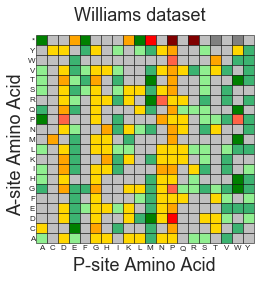

In [94]:
# Get the percent change values for all 420 pair combinations in the 6 datasets
dict_percent_change = {}
# Get the FDR corrected pvalues for all 420 pair combinations in the 6 datasets
dict_pval = {}
# Get the sample sizes for all 420 combinations in the 6 datasets
dict_sample_sizes = {}
# Get the list of norm ribo densitiy for all instances of the pair and its control for all 420 combinations in the 6 datasets
dict_instances = {}


# Running the analysis for Williams dataset
dict_percent_change['Williams'], dict_pval['Williams'], dict_sample_sizes['Williams'], dict_instances['Williams'] = psite_asite_matrix(norm_ribo_density_dict['Williams'], dict_cdn_types)
fig = plot_asite_psite_matrix(dict_percent_change['Williams'], dict_pval['Williams'], 'Williams dataset', print_stats=True)
plt.show()

### Generating Fig. S1 for one column and one row of the matrix

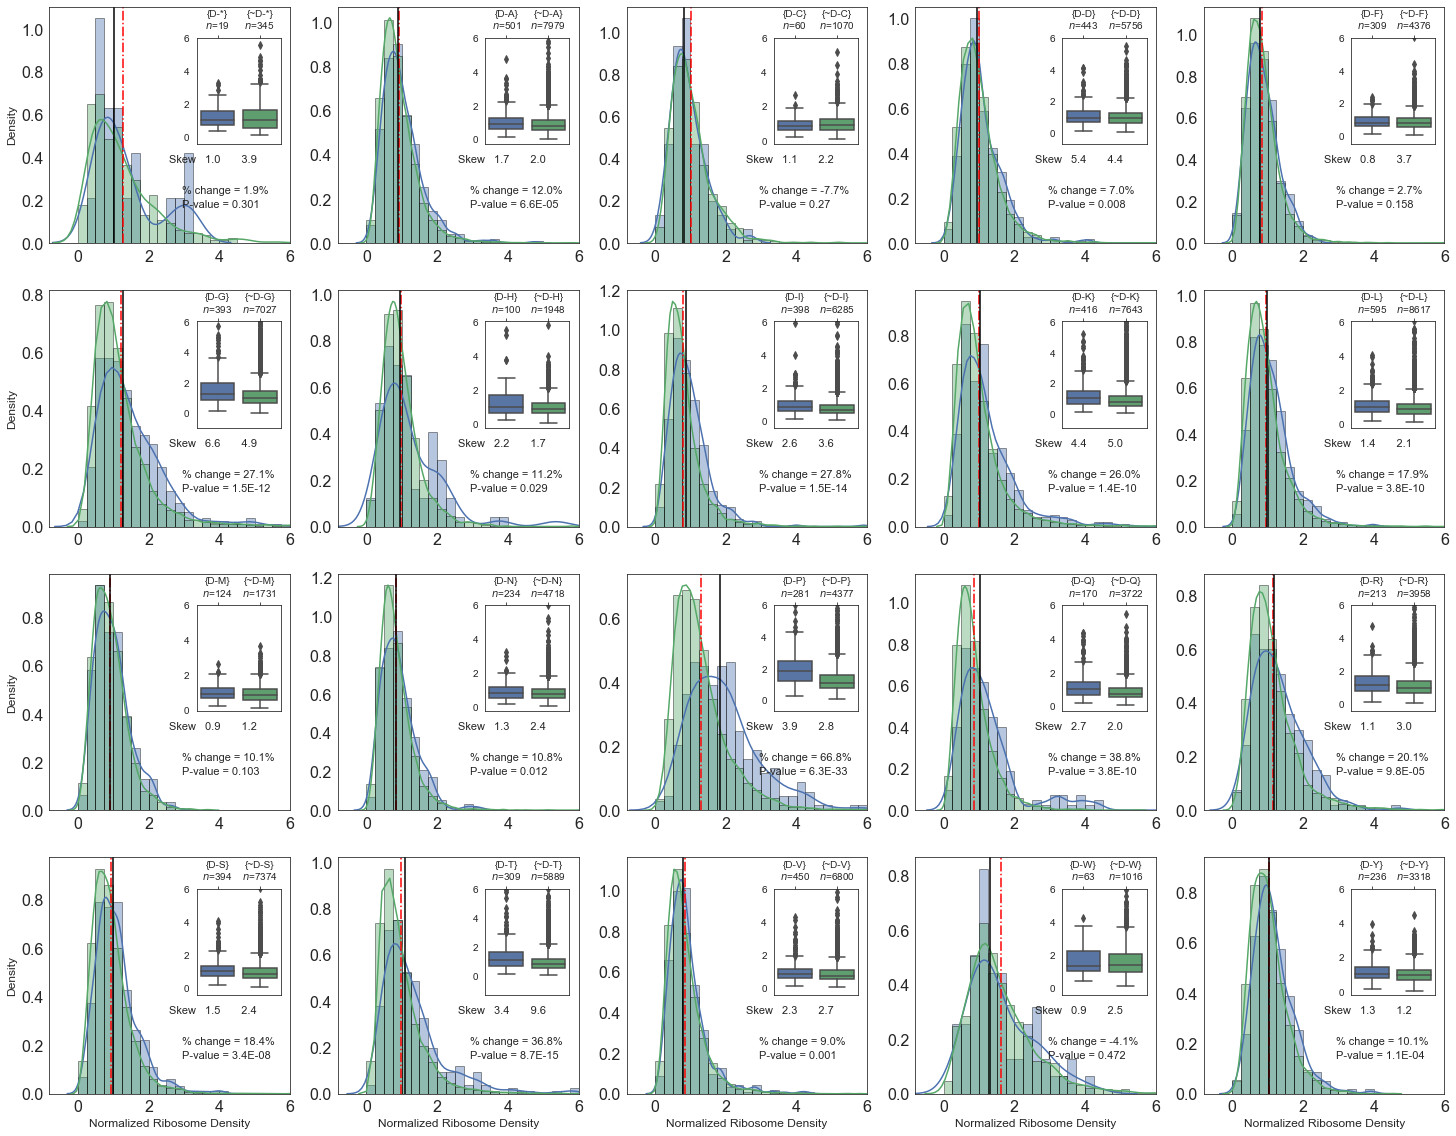

In [95]:
# Plotting Fig. S1 for a column of the above matrix 'D' and for a row of the above matrix 'E'


# Generating Fig. S1b below for the column 'D' of matrix for the Williams dataset shown above
plt.figure(figsize=(5 * 5, 20))
palette_colors = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]

sns.set_palette(palette_colors)
subplot_counter = 1
for as_aa in sorted(AMINO_ACIDS):
    # There are total 21 distributions possible for D in the P-site. We will show one of them (D, E) in next plot
    if as_aa == 'E':
        continue
    ax = plt.subplot(4, 5, subplot_counter)
    if subplot_counter in [1, 6, 11, 16]:
        ylabel = True
    else:
        ylabel = False
    if subplot_counter in [16, 17, 18, 19, 20]:
        xlabel = True
    else:
        xlabel = False

    perc_change = dict_percent_change['Williams'][as_aa]['D']
    pval = dict_pval['Williams'][as_aa]['D']
    if pval > 0.001:
        pval = round(pval, 3)
    else:
        pval = '%.1E' % pval

    ax = plot_trans_distribution_subplot(ax, as_aa, 'D', dict_instances['Williams'], perc_change, pval, xlabel=xlabel, ylabel=ylabel) 
    subplot_counter += 1
plt.show()

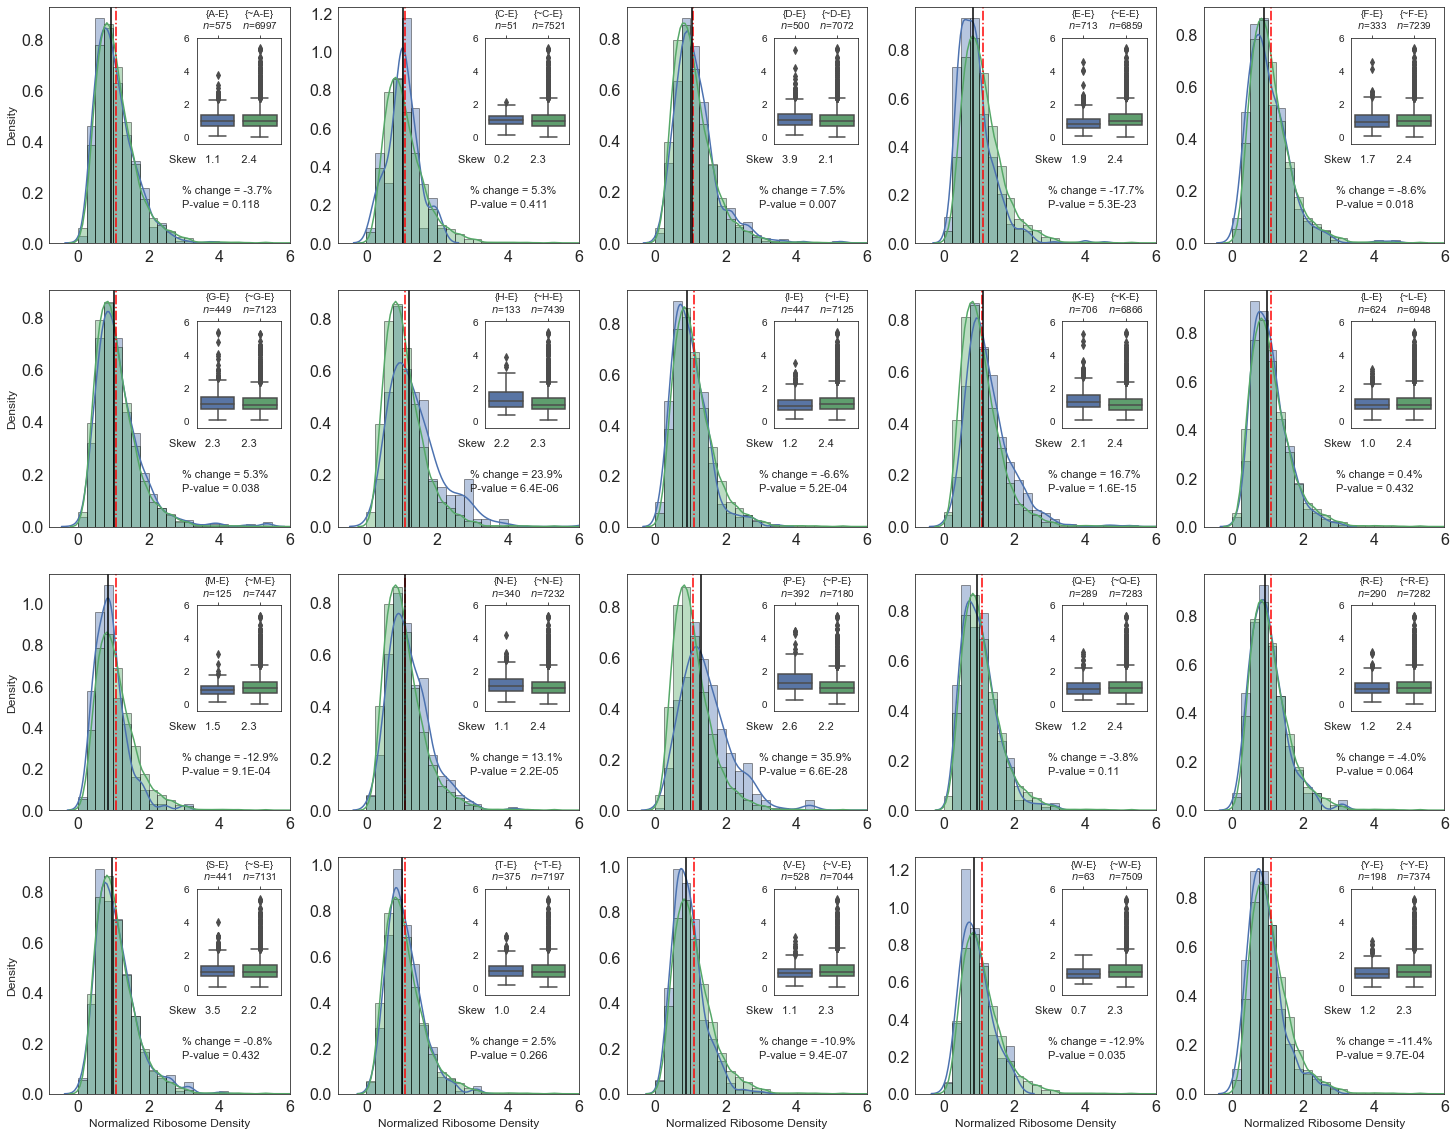

In [96]:
# Generating Fig. S1a below for the row 'E' of the matrix for the Williams dataset
plt.figure(figsize=(5 * 5, 20))
palette_colors = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]
sns.set_palette(palette_colors)
sns.set_style("white")

subplot_counter = 1
for ps_aa in sorted(AMINO_ACIDS):
    if ps_aa == '*':
        continue
    if subplot_counter in [1, 6, 11, 16]:
        ylabel = True
    else:
        ylabel = False
    if subplot_counter in [16, 17, 18, 19, 20]:
        xlabel = True
    else:
        xlabel = False
    perc_change = dict_effect_size['Williams']['E'][ps_aa]
    pval = dict_pval['Williams']['E'][ps_aa]
    if pval > 0.001:
        pval = round(pval, 3)
    else:
        pval = '%.1E' % pval
    ax = plt.subplot(4, 5, subplot_counter)
    ax = plot_trans_distribution_subplot(ax, 'E', ps_aa, dict_instances['Williams'], perc_change, pval, xlabel=xlabel, ylabel=ylabel)
    subplot_counter += 1

plt.show()

## Generating Fig. S2 which creates the P-site A-site matrices for the 6 datasets

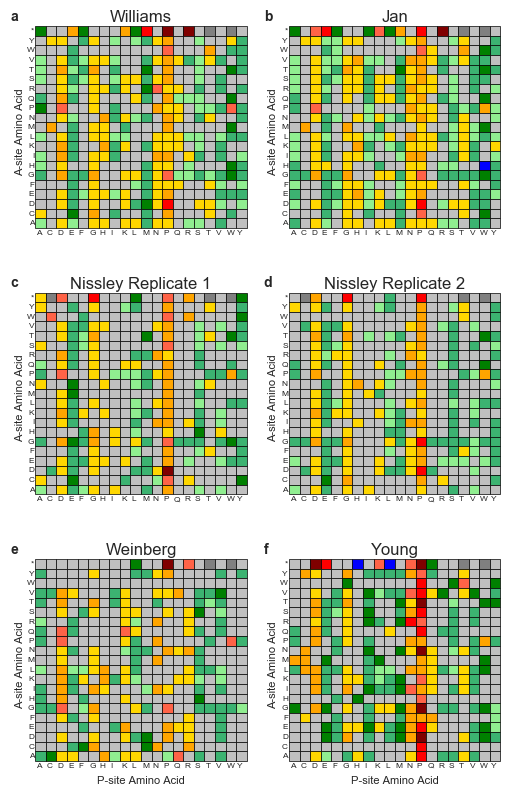

In [138]:
# Creating Fig. S2 that shows the P-site A-site matrix for the six datasets

# Creating a figure object
fig = plt.figure(figsize=(6, 10), dpi=100)

# Reducing the distance by half (default is 6) between the title and the subplot
rcParams['axes.titlepad'] = 3

counter = 1
fig_panel = {'Williams': 'a', 'Jan': 'b', 'Nissley1': 'c', 'Nissley2': 'd', 'Weinberg': 'e', 'Young': 'f'}
for dataset in datasets:
    dict_percent_change[dataset], dict_pval[dataset], dict_sample_sizes[dataset], dict_instances[dataset] = psite_asite_matrix(norm_ribo_density_dict[dataset], dict_cdn_types)
    ax = fig.add_subplot(3, 2, counter)
    ap_matrix, ap_matrix_pval = get_matrix_dataframe(dict_percent_change[dataset], dict_pval[dataset])
    if counter in [5, 6]:
        xlabel = True
    else:
        xlabel = False
    
    ax, pairs_stats = checkerboard_table_subplot(ap_matrix, ap_matrix_pval, ax=ax, xlabel=xlabel)
    ax.tick_params(width=1, length=4, axis='both', which='major', labelsize=6, pad=2)
    if dataset == "Nissley1":
        ax.set_title("Nissley Replicate 1", fontsize=12)
    elif dataset == "Nissley2":
        ax.set_title("Nissley Replicate 2", fontsize=12)
    else:
        ax.set_title(dataset, fontsize=12)
    ax.text(-0.12 * ax.get_xlim()[1], 1.025 * ax.get_ylim()[1], fig_panel[dataset], fontsize=10, fontweight='bold')
    counter += 1

# This is Fig. S2 in the study
plt.show()

## Determing robustness of pairs and plotting the robust matrix which is shown in Fig. 1b of the study

Total possible P-site and A-site pairs: 420
Total pairs that are robust across the datasets: 167
Total pairs that are robust and slow-translating pairs: 81
Total pairs that are robust and slow-translating pairs: 86


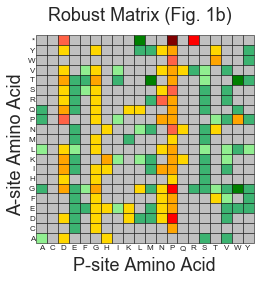

In [134]:
# Determing the robustness of the effect seen for pairs across the 6 datasets and generating a robust matrix that forms the Fig. 1b in the study

matrix_plot, pair_stats = measure_robustness_of_pairs(datasets, dict_percent_change, dict_pval)
plt.show()